# RGI06 (Iceland)

F. Maussion & S. Galos

Strictly equivalent to RGI6

In [1]:
import pandas as pd
import geopandas as gpd
import subprocess
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np
from utils import mkdir, submission_summary, needs_size_filter, size_filter, plot_map, plot_date_hist
import os

## Files and storage paths

In [2]:
# Region of interest
reg = 6

# go down from rgi7_scripts/workflow
data_dir = '../../rgi7_data/'

# Level 2 GLIMS files
l2_dir = os.path.join(data_dir, 'l2_sel_reg_tars')

# Output directories
output_dir = mkdir(os.path.join(data_dir, 'l3_rgi7a'))
output_dir_tar = mkdir(os.path.join(data_dir, 'l3_rgi7a_tar'))

# RGI v6 file for comparison later 
rgi6_reg_file = os.path.join(data_dir, 'l0_RGIv6', '06_rgi60_Iceland.zip')

In [3]:
# Specific to this region: RGI is made up by a series of spatially overlapping datasets
# selection of subsets is based on boxes which define areas for respective subset selection

support_dir = os.path.join(data_dir, 'l0_support_data')
box_file = os.path.join(support_dir, 'Iceland.tar.gz')

### Load the input data

In [4]:
# Read L2 files
shp = gpd.read_file('tar://' + l2_dir + f'/RGI{reg:02d}.tar.gz/RGI{reg:02d}/RGI{reg:02d}.shp')

### List of submissions 

In [5]:
sdf, _ = submission_summary(shp)
sdf

,N,A,analysts,submitters,release_date,geog_area,src_date_mode,src_date_min,src_date_max
subm_id,,,,,,,,,
437,70,8170.6,Sigurdsson,Sigurdsson,2007,Iceland,1999,1999,2000
438,15,159.3,Sigurdsson,Sigurdsson,2007,Iceland,2004,2004,2004
439,184,144.5,Sigurdsson,Sigurdsson,2007,Iceland,2000,2000,2000
452,51,2585.5,Sigurdsson,Sigurdsson,2007,Iceland,1999,1999,2001
719,365,10947.5,Sigurdsson,Sigurdsson,2014,Randolph Glacier Inventory; Umbrella RC for me...,2000,1999,2004


In [6]:
# # Write out selection in intermediate shape files for manual GIS review
# tmp_output_dir = mkdir(os.path.join(data_dir, 'l0_tmp_data', f'rgi{reg:02d}_inventories'))
# tmp_output_dir_tar = mkdir(os.path.join(data_dir, 'l0_tmp_data'))
# for subid in shp.subm_id.unique():
#     s_loc = shp.loc[shp.subm_id == subid]
#     s_loc.to_file(tmp_output_dir + f'/subm_{int(subid):03d}.shp')
# print('Taring...')
# print(subprocess.run(['tar', '-zcvf', f'{tmp_output_dir_tar}/rgi{reg:02d}_inventories.tar.gz', '-C', 
#                       os.path.join(data_dir, 'l0_tmp_data'), f'rgi{reg:02d}_inventories']))

## Apply selection criteria to create the RGI7 data subset

### Extract RGI6 from GLIMS data and do a check

In this special case RGI06 was made up from several files. Submission id 719 was added to GLIMS to document applied changes in glacier devides for RGI6 so data set serves as the baseline, we then add those parts of other submissions which are not covered by subm_id 719. To extract those we apply an overlay of representative points of each file and the polygons of subm_id 719.   

In [7]:
# define subsets according to submission id
sub_719 = shp.loc[shp['subm_id']==719]
sub_437 = shp.loc[shp['subm_id']==437]
sub_438 = shp.loc[shp['subm_id']==438]
sub_439 = shp.loc[shp['subm_id']==439]
sub_452 = shp.loc[shp['subm_id']==452]

### Extract relevant subset of each submission based on overlay with manually defined boxes

In [8]:
# load shapes
AOI_437 = gpd.read_file('tar://' + box_file + '/Iceland/AOI_437.shp')
AOI_438 = gpd.read_file('tar://' + box_file + '/Iceland/AOI_438.shp')
AOI_439 = gpd.read_file('tar://' + box_file + '/Iceland/AOI_439.shp')
AOI_452 = gpd.read_file('tar://' + box_file + '/Iceland/AOI_452.shp')

In [9]:
## extract relevant subsets by overlay

# 437
sub437_ss = gpd.overlay(sub_437, AOI_437, how='intersection')

# 438
sub438_ss = gpd.overlay(sub_438, AOI_438, how='intersection')

# 439
sub439_ss = gpd.overlay(sub_439, AOI_439, how='intersection')

# 452
sub452_ss = gpd.overlay(sub_452, AOI_452, how='intersection')

In [10]:
# append to subm 719 in order to create RGI regional subset
rgi7 = sub_719.append([sub437_ss, sub438_ss, sub439_ss, sub452_ss], sort=True)

### Some sanity checks 

In [11]:
sdf, df_class = submission_summary(rgi7)
df_class

,N,N NA,N Ice cap
subm_id,,,
719,365,365,0
437,26,26,0
438,5,5,0
439,155,154,1
452,16,15,1


In [12]:
# Nothing should change here
rgi7['is_rgi6'] = True

In [13]:
# Check the orphaned rock outcrops
orphan_f = os.path.join(data_dir, 'l1_orphan_interiors', f'RGI{reg:02d}', f'RGI{reg:02d}.shp')
if os.path.exists(orphan_f):
    orphan_f = gpd.read_file(orphan_f)
    if np.any(np.isin(rgi7.subm_id.unique(), orphan_f.subm_id.unique())):
        print('Orphan rock outcrops detected.')

### Plots 

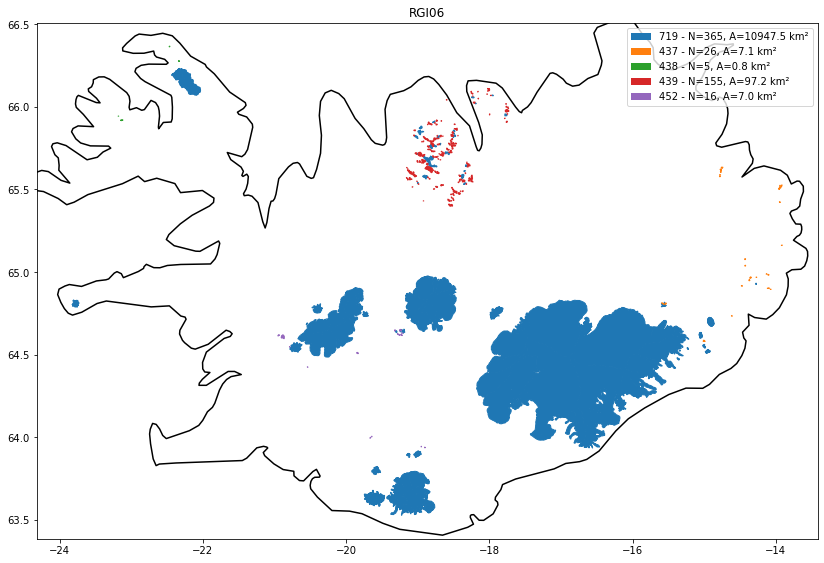

In [14]:
plot_map(rgi7, reg)

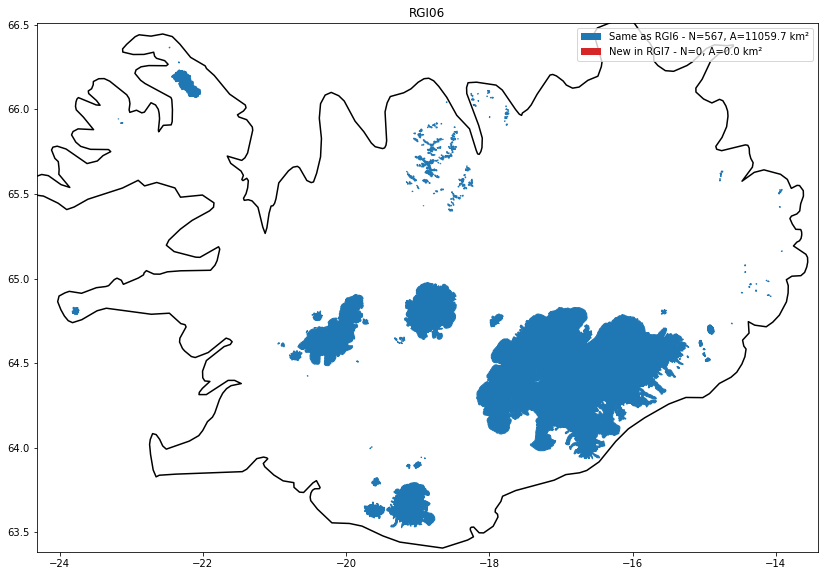

In [15]:
plot_map(rgi7, reg, is_rgi6=True)

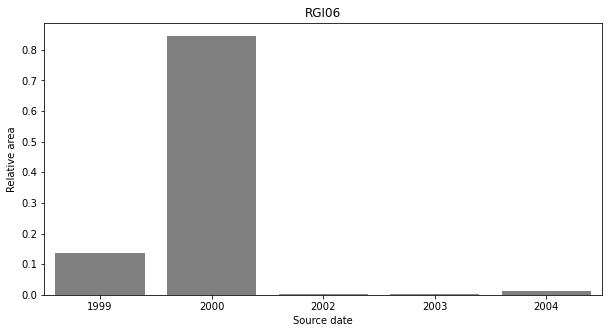

In [16]:
plot_date_hist(rgi7, reg)

### Text for github

In [17]:
fgh = sdf.T
fgh

subm_id,719,437,438,439,452
N,365,26,5,155,16
A,10947.5,7.1,0.8,97.2,7.0
analysts,Sigurdsson,Sigurdsson,Sigurdsson,Sigurdsson,Sigurdsson
submitters,Sigurdsson,Sigurdsson,Sigurdsson,Sigurdsson,Sigurdsson
release_date,2014,2007,2007,2007,2007
geog_area,Randolph Glacier Inventory; Umbrella RC for me...,Iceland,Iceland,Iceland,Iceland
src_date_mode,2000,1999,2004,2000,1999
src_date_min,1999,1999,2004,2000,1999
src_date_max,2004,1999,2004,2000,2000


In [18]:
print(fgh.to_markdown(headers=np.append(['subm_id'], fgh.columns)))

| subm_id       | 719                                                                    | 437        | 438        | 439        | 452        |
|:--------------|:-----------------------------------------------------------------------|:-----------|:-----------|:-----------|:-----------|
| N             | 365                                                                    | 26         | 5          | 155        | 16         |
| A             | 10947.5                                                                | 7.1        | 0.8        | 97.2       | 7.0        |
| analysts      | Sigurdsson                                                             | Sigurdsson | Sigurdsson | Sigurdsson | Sigurdsson |
| submitters    | Sigurdsson                                                             | Sigurdsson | Sigurdsson | Sigurdsson | Sigurdsson |
| release_date  | 2014                                                                   | 2007       | 2007       | 2007       | 2007       |

## Write out and tar 

In [19]:
dd = mkdir(f'{output_dir}/RGI{reg:02d}/', reset=True)

print('Writing...')
rgi7.to_file(dd + f'RGI{reg:02d}.shp')

print('Taring...')
print(subprocess.run(['tar', '-zcvf', f'{output_dir_tar}/RGI{reg:02d}.tar.gz', '-C', output_dir, f'RGI{reg:02d}']))

Writing...
Taring...
CompletedProcess(args=['tar', '-zcvf', '../../rgi7_data/l3_rgi7a_tar/RGI06.tar.gz', '-C', '../../rgi7_data/l3_rgi7a', 'RGI06'], returncode=0)


### load reference data (here RGI6) to enable comparison

In [20]:
# load reference data
from utils import open_zip_shapefile
ref_odf = open_zip_shapefile(rgi6_reg_file)

#### Number of elements (differences depict problems)

In [21]:
print('Number of glaciers in new RGI subset:', len(rgi7))
print('Number of glaciers in reference data:', len(ref_odf))
print('Difference:', len(rgi7)-len(ref_odf))

Number of glaciers in new RGI subset: 567
Number of glaciers in reference data: 568
Difference: -1


In [22]:
# how many nominals in RGI06 (identifiable via 'Status' attribute in RGI 06)
nom = ref_odf.loc[ref_odf.Status == 2]
len(nom)

0

#### Total area

In [23]:
# add an area field to RGI_ss and reference data
ref_odf['area'] = ref_odf.to_crs({'proj':'cea'}).area

In [24]:
# print and compare area values
Area_RGI = rgi7['area'].sum()/1000000
print('Area RGI [km²]:', Area_RGI)
Area_ref = ref_odf['area'].sum()/1000000
print('Area Ref [km²]:', Area_ref)
d = (Area_RGI - Area_ref)
print('Area difference:',d, 'km²')

Area RGI [km²]: 11059.703473894138
Area Ref [km²]: 11059.70349144711
Area difference: -1.7552971257828176e-05 km²


### Find the missing glacier 

In [25]:
# Rename things
df_ref = ref_odf

In [26]:
from utils import haversine
import progressbar
import numpy as np

In [27]:
def xy_coord(geom):
    """To compute CenLon CenLat ourselves"""
    x, y = geom.xy
    return x[0], y[0]

In [28]:
# compute CenLon CenLat ourselves
rp = df_ref.representative_point()

coordinates = np.array(list(rp.apply(xy_coord)))
df_ref['CenLon'] = coordinates[:, 0]
df_ref['CenLat'] = coordinates[:, 1]

In [29]:
df_ref_orig = df_ref.copy()

In [30]:
# Loop over all RGI7 glaciers and find their equivalent in ref
df_ref = df_ref_orig.copy()
not_found = {}
to_drop = []
for i, (ref_area, lon, lat) in progressbar.progressbar(enumerate(zip(rgi7['area'].values, rgi7.CenLon.values, rgi7.CenLat.values)), max_value=len(rgi7)):
#     dist = haversine(lon, lat, df_ref.CenLon.values, df_ref.CenLat.values)
    dist = (lon - df_ref.CenLon.values)**2 + (lat - df_ref.CenLat.values)**2 
    found = False
    for j in np.argsort(dist)[:10]:
        s6 = df_ref.iloc[j]
        if np.allclose(s6['area'], ref_area, rtol=0.01):
            found = True
            to_drop.append(s6.name)
            break
    if not found:
        not_found[i] = df_ref.iloc[np.argsort(dist)[:10]]
    if len(to_drop) > 1000:
        df_ref.drop(labels=to_drop, inplace=True)
        to_drop = []
df_ref.drop(labels=to_drop, inplace=True)

100% (567 of 567) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


In [31]:
print(len(not_found), len(df_ref))

1 2


In [32]:
pb_rgi7 = rgi7.iloc[list(not_found.keys())]

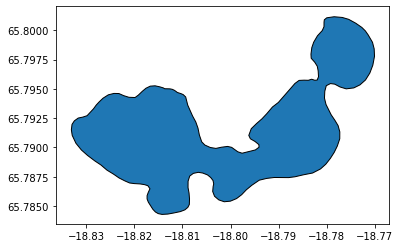

In [33]:
rgi7.iloc[list(not_found.keys())].plot(edgecolor='k');

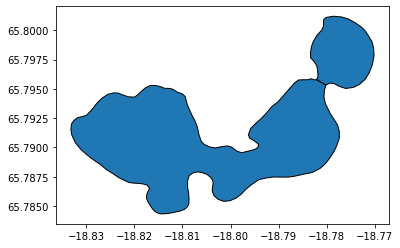

In [34]:
df_ref.plot(edgecolor='k');

We have found the problem! Reported here: https://trello.com/c/Q7QOMnkA

In [35]:
# Output directories
output_dir = mkdir(os.path.join(data_dir, 'l3_problem_glaciers'))
output_dir_tar = mkdir(os.path.join(data_dir, 'l3_problem_glaciers_tar'))

In [36]:
dd = mkdir(f'{output_dir}/RGI{reg:02d}/', reset=True)

print('Writing...')
pb_rgi7.to_file(dd + f'RGI{reg:02d}_glims.shp')
df_ref.to_file(dd + f'RGI{reg:02d}_ref.shp')

print('Taring...')
print(subprocess.run(['tar', '-zcvf', f'{output_dir_tar}/RGI{reg:02d}.tar.gz', '-C', output_dir, f'RGI{reg:02d}']))

Writing...
Taring...
CompletedProcess(args=['tar', '-zcvf', '../../rgi7_data/l3_problem_glaciers_tar/RGI06.tar.gz', '-C', '../../rgi7_data/l3_problem_glaciers', 'RGI06'], returncode=0)
